Welcome back! In this post, we'll walk through building some image classification models using Keras to distinguish between cats and dog.

We'll start with a very simple model and then enhance it step by step. Let's get started!

## Prepare our Data

### Preparing the Environment

Let's set up the environment and load our dataset.

In [1]:
import os
import keras
from keras import utils
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

We'll use the "Cat VS Dog" dataset from TensorFlow Datasets. Here, we're going to create three datasets for training, validation, and testing.

In [2]:
train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # 40% for training, 10% for validation, and 10% for test (the rest unused)
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {validation_ds.cardinality()}")
print(f"Number of test samples: {test_ds.cardinality()}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.OIMOKT_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


The images in the dataset come in various sizes, thus we need to reize them to a fixed size before feeding them into our model.

In [3]:
# resize images to a fixed size of 150x150
resize_fn = keras.layers.Resizing(150, 150)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))

#  rapidly read data
from tensorflow import data as tf_data
batch_size = 64

train_ds = train_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
validation_ds = validation_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
test_ds = test_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()

### Inspecting the Data

Before actually building any model, we should explore our data to understand we're dealing with here. To do that, let's create a visualization function to display three random cats in a row and three random dogs in the other row.

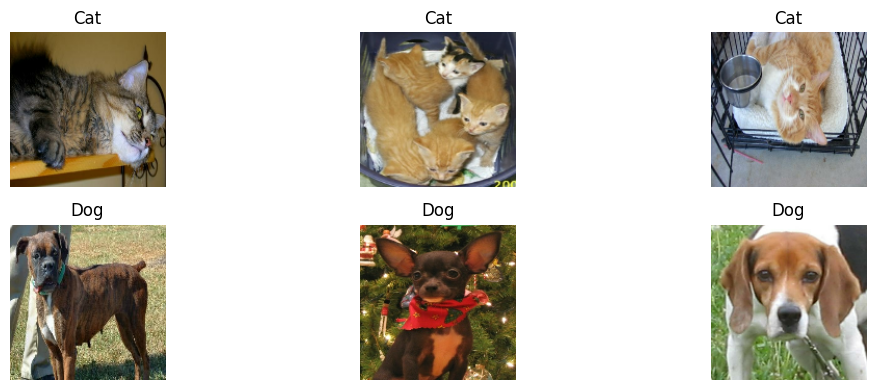

In [4]:
def two_row_vis(dataset):

    cats = []
    dogs = []

    for images, labels in dataset.take(1):  # Take one batch

        for i in range(len(labels)):
            image = images[i].numpy() / 255.0  # Normalize to [0,1]
            label = labels[i].numpy()

            if label == 0 and len(cats) < 3:  # Cat
                cats.append(image)
            elif label == 1 and len(dogs) < 3:  # Dog
                dogs.append(image)

            # Break if we have enough examples
            if len(cats) >= 3 and len(dogs) >= 3:
                break

    # Create a 2x3 grid
    fig, axes = plt.subplots(2, 3, figsize=(12, 4))

    # Display 3 cats in the first row
    for i in range(3):
        axes[0, i].imshow(cats[i])
        axes[0, i].set_title("Cat")
        axes[0, i].axis("off")

    # Display 3 dogs in the second row
    for i in range(3):
        axes[1, i].imshow(dogs[i])
        axes[1, i].set_title("Dog")
        axes[1, i].axis("off")

    plt.tight_layout()
    return fig

fig = two_row_vis(train_ds)
plt.show()

Lovely images! Now, we can check the frequencies of labels in the training dataset. This is necessary for obtaining the **baseline** model, which predicts the most frequent label.

In [5]:
labels_iterator= train_ds.unbatch().map(lambda image, label: label).as_numpy_iterator()

In [6]:
cat_num = 0
dog_num = 0

# Count cats and dogs
for label in labels_iterator:
    if label == 0:  # Cat
        cat_num += 1
    else:  # Dog (label 1)
        dog_num += 1

print(f"Number of cats: {cat_num}")
print(f"Number of dogs: {dog_num}")

total_num = cat_num + dog_num
baseline_accuracy = max(cat_num, dog_num) / total_num
print(f"Baseline accuracy: {baseline_accuracy*100:.2f}%")

Number of cats: 4637
Number of dogs: 4668
Baseline accuracy: 50.17%


As you can see, our dataset has an almost equal distribution of cats and dogs. As a result, the baseline accuracy would be around **50%**. This will be treated as the benchmark for improving our models. Now, we're ready to design models to outperform this baseline!

## Build Models

### First Model

Let's start by creating a very basic convolutional neural network model.

In [30]:
model1 = keras.Sequential([
    # Input layer with the shape of our images
    keras.layers.Input(shape=(150, 150, 3)),

    # Convolutional blocks
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),

    # Flatten and feed through dense layers
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),

    # Output layer for binary classification
    keras.layers.Dense(1, activation='sigmoid')
])

 I have experimented with a few variations before getting a relatively satisfying validation accuracy. I started with only two Conv2D + MaxPooling blocks, few filters (16,32) and small drop out rate (0.2). After a few trials and errors, this is what we have:

In [31]:
model1.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 128)                 │      10,616,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,636,481 (40.57 MB)

 Trainable params: 10,636,481 (40.57 MB)

 Non-trainable params: 0 (0.00 B)

Let's try compiling and training the model:

In [32]:
def run(model, train_ds, validation_ds, optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], epochs=20):
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=validation_ds
    )

    return history

In [33]:
history1 = run(model1, train_ds, validation_ds)

Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.5309 - loss: 122.3075 - val_accuracy: 0.5658 - val_loss: 0.6795
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.6114 - loss: 0.6391 - val_accuracy: 0.5808 - val_loss: 0.6876
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7030 - loss: 0.5489 - val_accuracy: 0.5851 - val_loss: 0.7333
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.7622 - loss: 0.4758 - val_accuracy: 0.5666 - val_loss: 0.7588
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.7991 - loss: 0.4119 - val_accuracy: 0.5929 - val_loss: 0.7944
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8132 - loss: 0.4080 - val_accuracy: 0.6028 - val_loss: 0.8800
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8230 - loss: 0.3700 - val_accuracy: 0.6032 - val_loss: 0.9814
Epoch 8/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.8755 - loss: 0.2940 - val_a

Let's plot the history of the accuracy on both the training and validation sets for the first model.

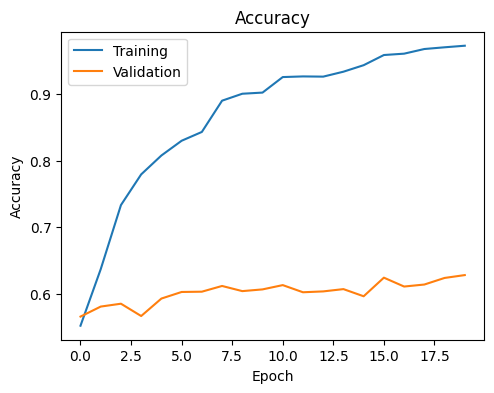

In [34]:
def accuracy_his_vis(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Validation'])
    plt.show()

accuracy_his_vis(history1)

As visualized in the plot, **the validation accuracy of our first model stabilized around 60% during training**. Compared to the baseline (~50%), the first model is slightly bettern with about 10% improvement. This is not bad.

Besides, there's obvious overfitting in this model. The training accuracy climbs high rapidly, while the validation accuracy is much lower and reaches plateau after a few epochs. This suggests that the model is memorizing the training data, instead of learning patterns.

### Data Augmentation

To improve our model, one useful method is data augmentation. Basically, we can create modified copies of the same image and introduce some variability artificially. This would teach the model to be invariant to transformations and slow down overfitting.

Here, we're going to include two kinds of transformations: flipping and rotating. Let's take a look at the result of applying `RandomFlip` and `RandomRotation`.

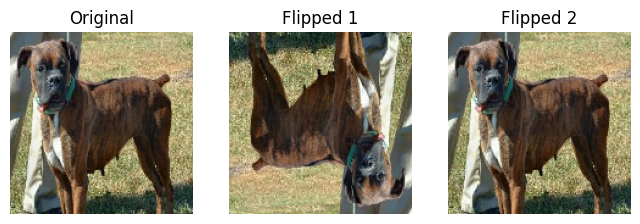

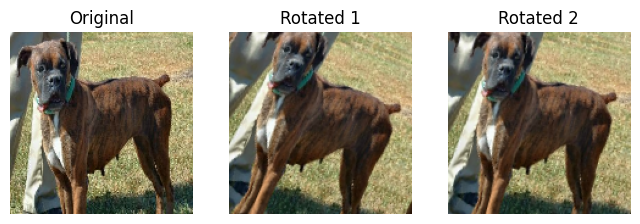

In [13]:
# Get an image
for images, _ in train_ds.take(1):
  sample = images[0].numpy()
  break

# Visualize the augmented result
def augment_vis(sample, layer, title, copies=2):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, copies + 1, 1)
    plt.imshow(sample.astype("uint8"))
    plt.title("Original")
    plt.axis("off")

    for i in range(copies):
        transformed = layer(tf.expand_dims(sample, 0))
        plt.subplot(1, copies + 1, i + 2)
        plt.imshow(transformed[0].numpy().astype("uint8"))
        plt.title(f"{title} {i+1}")
        plt.axis("off")

    plt.show()

# Define augmentation layers
flip = keras.layers.RandomFlip("horizontal_and_vertical")
rotate = keras.layers.RandomRotation(0.2)

# Visualize augmentations
augment_vis(sample, flip, "Flipped")
augment_vis(sample, rotate, "Rotated")

Great! Now, we can create a new model that include the augmentation layers as the first two layers.

In [39]:
model2 = keras.Sequential([

    keras.layers.Input(shape=(150, 150, 3)),

    # Data augmentation layers
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),

    # Convolutional blocks
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),

    # Flatten and dense layers
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),

    # Output layer
    keras.layers.Dense(1, activation='sigmoid')
])

model2.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_10 (RandomFlip)          │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_10 (RandomRotation)  │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 128)                 │      10,616,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,636,481 (40.57 MB)

 Trainable params: 10,636,481 (40.57 MB)

 Non-trainable params: 0 (0.00 B)

Let's compile and train the second model:

In [40]:
history2 = run(model2, train_ds, validation_ds)

Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 60s 41ms/step - accuracy: 0.5367 - loss: 98.6324 - val_accuracy: 0.5460 - val_loss: 0.6813
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.5395 - loss: 0.6887 - val_accuracy: 0.5421 - val_loss: 0.6845
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5387 - loss: 0.6884 - val_accuracy: 0.5460 - val_loss: 0.6823
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.5444 - loss: 0.6855 - val_accuracy: 0.5537 - val_loss: 0.6837
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5531 - loss: 0.6817 - val_accuracy: 0.5701 - val_loss: 0.6789
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.5714 - loss: 0.6811 - val_accuracy: 0.5782 - val_loss: 0.6745
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.5571 - loss: 0.6814 - val_accuracy: 0.5847 - val_loss: 0.6677
Epoch 8/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5675 - loss: 0.6780 - val_

Let's visualize the training and validation accuracy for the second model.

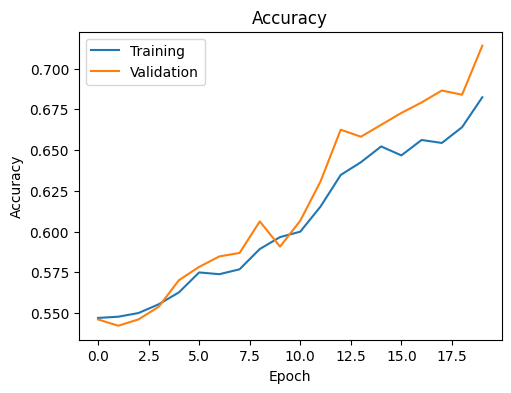

In [41]:
accuracy_his_vis(history2)

As you can see, **the validation accuracy of our second model reached 70% and stabilized above 65%** this time.

While the second model does not always perform better than the first model, we can still see an improvement that might become more obvious over time.

There's still some overfitting here, but the gap between training and validation accuracy is much smaller compared to the previous model. This indicates that our model is generalizing better to unseen data.

### Data Preprocessing

We can try to improve our model further. It can be helpful to make simple transformations to the input data. For example, we can scale the pixel values of the original data from [0, 255] to [-1, 1] before the training process. This will help the model train faster. In the meantime, more training energy can be used to handle actual signal in the data.

As such, let's create a model with both data preprocessing and augmentation layers:

In [42]:
def preprocess():
    i = keras.Input(shape=(150, 150, 3))
    scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
    x = scale_layer(i)
    preprocessor = keras.Model(inputs = i, outputs = x)
    return preprocessor

preprocessor = preprocess()

model3 = keras.Sequential([

    keras.layers.Input(shape=(150, 150, 3)),

    # Preprocessing layer
    preprocessor,

    # Data augmentation layers
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),

    # Convolutional blocks
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),

    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),

    # Flatten and dense layers
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),

    # Output layer
    keras.layers.Dense(1, activation='sigmoid')
])

model3.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional_13 (Functional)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_11 (RandomFlip)          │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_11 (RandomRotation)  │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 256)                 │       9,470,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,596,481 (36.61 MB)

 Trainable params: 9,596,481 (36.61 MB)

 Non-trainable params: 0 (0.00 B)

Let's compile and train the third model:

In [43]:
history3 = run(model3, train_ds, validation_ds)

Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.5450 - loss: 0.7041 - val_accuracy: 0.7158 - val_loss: 0.5650
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.6769 - loss: 0.5955 - val_accuracy: 0.7653 - val_loss: 0.4985
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.7313 - loss: 0.5353 - val_accuracy: 0.7790 - val_loss: 0.4796
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.7523 - loss: 0.5112 - val_accuracy: 0.7863 - val_loss: 0.4547
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.7746 - loss: 0.4783 - val_accuracy: 0.7816 - val_loss: 0.4814
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.7795 - loss: 0.4665 - val_accuracy: 0.8044 - val_loss: 0.4312
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.7883 - loss: 0.4492 - val_accuracy: 0.8250 - val_loss: 0.4156
Epoch 8/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8069 - loss: 0.4296 - val_a

Just like the previous ones, we can visualize the accuracy of training and validation.

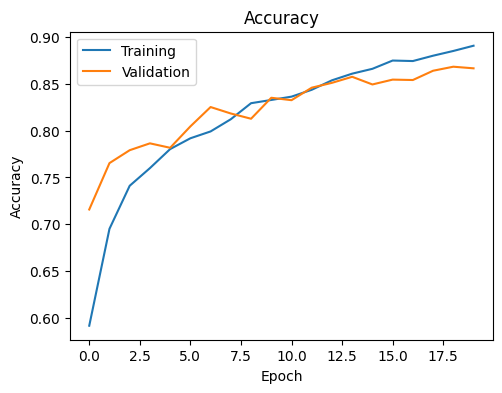

In [44]:
accuracy_his_vis(history3)

Impressive! Now **the validation accuracy stabilized between 80% and 85%**. This is a significant improvement over the previous two models.

The validation accuracy at the start is even higher than the final validation accuracy in the first model. This indicates that prepocessing make the third
model train much more effectively.

Besides, there's still some overfitting toward the end of training. But overall, it is much better compared to the first model.

### Transfer Learning

So far, we've been training models from scratch. But sometimes, it might be more efficient to use a pre-existing model for our image classification task.

Let's access a “base model” (`MobileNetV3Large`) and use it to train our model.

In [45]:
IMG_SHAPE = (150, 150, 3)
base_model = keras.applications.MobileNetV3Large(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet')
base_model.trainable = False

i = keras.Input(shape=IMG_SHAPE)
x = base_model(i, training = False)
base_model_layer = keras.Model(inputs = i, outputs = x)

model4 = keras.Sequential([

    keras.layers.Input(shape=(150, 150, 3)),

    # Data augmentation
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(0.3),

    # Base model layer
    base_model_layer,

    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.2),

    # Output layer
    keras.layers.Dense(1, activation='sigmoid')
])

model4.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_12 (RandomFlip)          │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_12 (RandomRotation)  │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_15 (Functional)           │ (None, 5, 5, 960)           │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 960)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 960)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 1)                   │             961 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,997,313 (11.43 MB)

 Trainable params: 961 (3.75 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

What's really remarkable here is that we're only training 961 parameters out of the 3 million total parameters! Let's see how it performs:

In [46]:
history4 = run(model4, train_ds, validation_ds)

Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.6438 - loss: 0.6878 - val_accuracy: 0.9579 - val_loss: 0.1479
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.8981 - loss: 0.2535 - val_accuracy: 0.9656 - val_loss: 0.1114
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9078 - loss: 0.2219 - val_accuracy: 0.9643 - val_loss: 0.1034
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.9112 - loss: 0.2021 - val_accuracy: 0.9656 - val_loss: 0.0973
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.9276 - loss: 0.1850 - val_accuracy: 0.9673 - val_loss: 0.0914
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.9281 - loss: 0.1807 - val_accuracy: 0.9703 - val_loss: 0.0850
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.9229 - loss: 0.1814 - val_accuracy: 0.9678 - val_loss: 0.0871
Epoch 8/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.9261 - loss: 0.1806 - val_acc

And of course, let's visualize the accuracy:

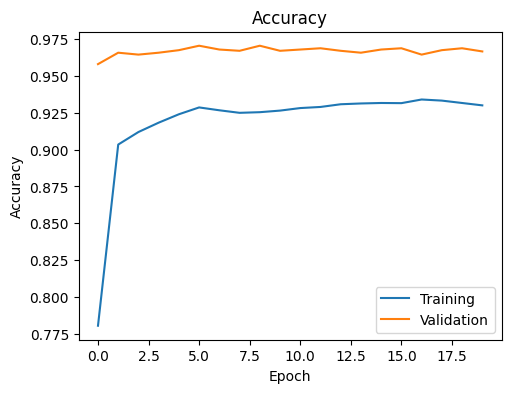

In [47]:
accuracy_his_vis(history4)

**The validation accuracy starts at over 95% and maintains this high performance throughout!**

Needless to say, the transfer-learned model demonstrates significantly superior validation accuracy compared to the first model.

Meanwhile, the fourth model shows no evidence of overfitting as well. The validation accuracy consistently exceeds training accuracy throughout the training process.

### Evaluating the Best Model

Finally, we can compare all four models we have created so far:

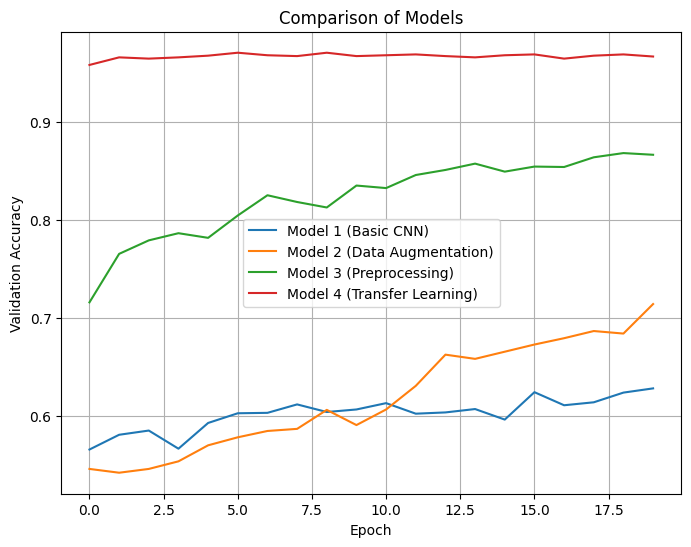

In [48]:
plt.figure(figsize=(8, 6))
plt.plot(history1.history['val_accuracy'], label='Model 1 (Basic CNN)')
plt.plot(history2.history['val_accuracy'], label='Model 2 (Data Augmentation)')
plt.plot(history3.history['val_accuracy'], label='Model 3 (Preprocessing)')
plt.plot(history4.history['val_accuracy'], label='Model 4 (Transfer Learning)')
plt.title('Comparison of Models')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

It is apparent that the most performent model is the last model that uses transfer learning. Let's evaluate the accuracy of the model on the unseen test dataset.

In [49]:
test_loss, test_accuracy = model4.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.4f}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.9620 - loss: 0.0965
Test accuracy: 0.9596


Looks good! We can visualize the result even more concretely by getting some images and generating some predictions:

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step


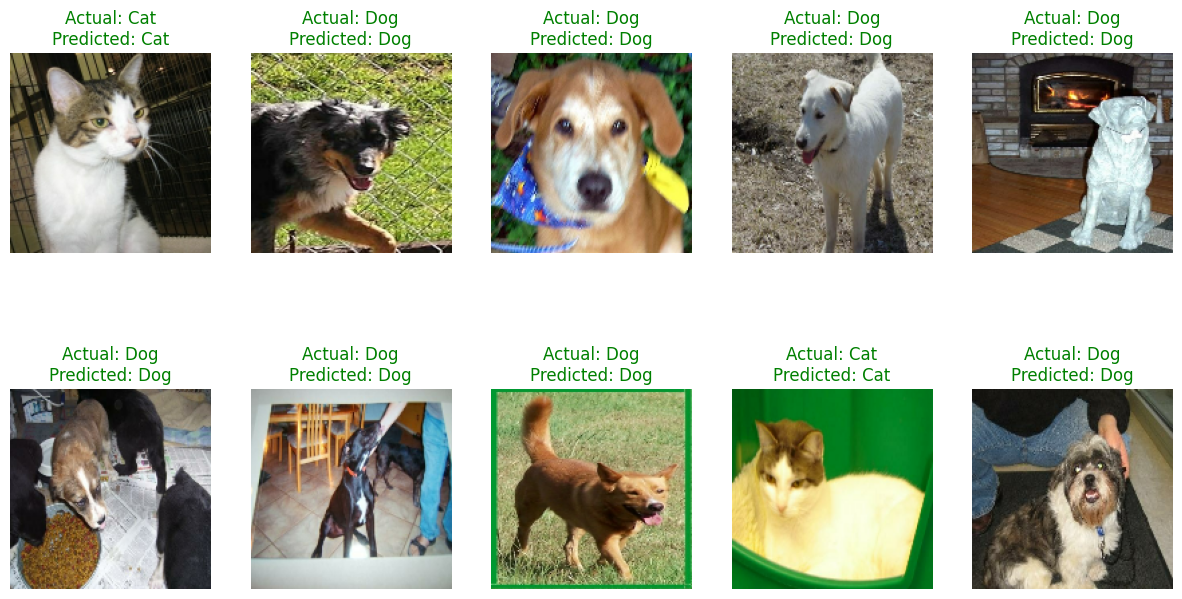

In [50]:
def pred_vis():
    # Get a batch of test images
    for images, labels in test_ds.take(1):
        # Get predictions
        predictions = model4.predict(images)
        predictions = [1 if p > 0.5 else 0 for p in predictions]

        # Display 10 images with predictions
        plt.figure(figsize=(15, 8))
        for i in range(10):
            plt.subplot(2, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            actual = "Dog" if labels[i].numpy() == 1 else "Cat"
            predicted = "Dog" if predictions[i] == 1 else "Cat"
            color = "green" if labels[i].numpy() == predictions[i] else "red"
            plt.title(f"Actual: {actual}\nPredicted: {predicted}", color=color)
            plt.axis("off")

        plt.show()


pred_vis()

Awesome! It seems that the model is really good at distinguishing cats from dogs! Now we've learned how to progressively improve an image classification model. Plus, an important takeaway is that we don't always need to build complex models from scratch.